# SAVi-DINOSAUR 実験レポート

**日付**: 2026年2月1日  
**目的**: 鏡面反射物体（Metal）の時間的一貫性を物体中心学習で評価する

## 1. 実験の狙い

### 背景
- 物体中心学習（Object-Centric Learning）は、画像・動画から個別の物体を教師なしで分離する手法
- 鏡面反射（specular reflection）を持つ物体は、視点・光源によって見えが大きく変化
- この見えの変化が物体追跡の安定性に影響するかを検証

### 研究課題
**「鏡面反射物体（Metal）はマット物体（Rubber）より追跡が難しいか？」**

### 使用モデル
- **SAVi** (Slot Attention for Video): フレーム間でスロットを引き継ぐ時間的Slot Attention
- **DINOSAUR**: DINOv2特徴量を使った物体中心学習
- 両者を組み合わせた **SAVi-DINOSAUR** を実装

## 2. 実験方法

### 2.1 データセット
- **MOVi-A**: Kubricで生成された合成動画データセット
- 24フレーム、256×256解像度
- 3-5個の物体（Metal/Rubber）が動く

| カテゴリ | サンプル数 | 説明 |
|---------|-----------|------|
| Metal-only | 20 | 全物体がMetal（鏡面反射あり） |
| Mixed | 40 | Metal/Rubberが混在 |

### 2.2 モデル構成

```
入力動画 (B, T, 3, 224, 224)
    ↓
DINOv2 ViT-S/14 [凍結] → 特徴量 (B, T, 384, 16, 16)
    ↓
Slot Attention (K=5 slots, 5 iterations)
    ↓
Slot Predictor [次フレーム予測]
    ↓
Feature Decoder → 再構成特徴量
```

### 2.3 学習設定

| パラメータ | 値 |
|-----------|----|
| エポック数 | 200 |
| バッチサイズ | 2 |
| 学習率 | 0.001 |
| スロット数 | 5 |
| フレーム数 | 12 |
| スケジューラ | CosineAnnealing |

### 2.4 損失関数
```
Loss = Reconstruction Loss + 0.1 × Diversity Loss
```

- **Reconstruction Loss**: DINOv2特徴量のMSE再構成誤差
- **Diversity Loss**: スロット間のコサイン類似度（スロット崩壊防止）

## 3. 実験結果

### 3.1 学習曲線

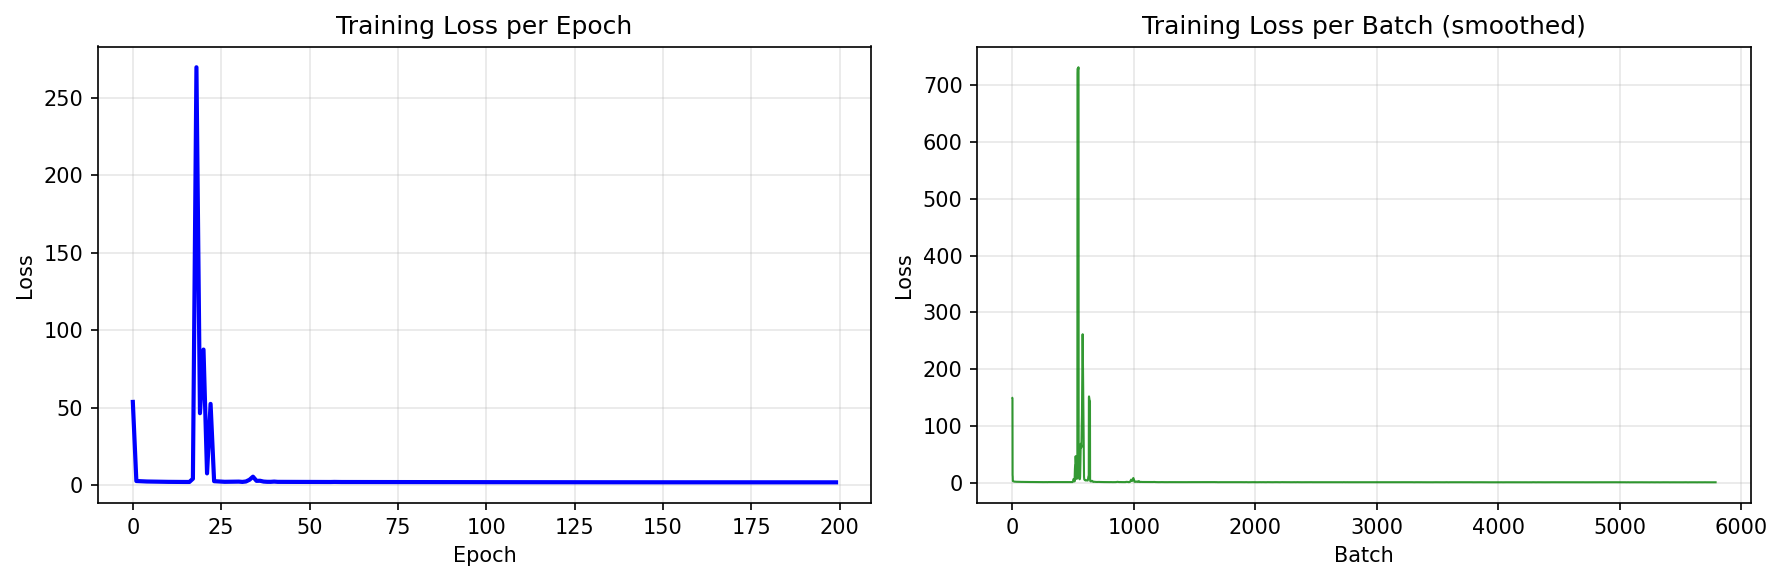

In [1]:
from IPython.display import Image, display

# 学習曲線
display(Image(filename='experiment_2026_02_01/training_history.png', width=800))

- 最終損失: **1.80**
- 多様性損失の追加により、スロット崩壊を防止できた

### 3.2 マスク可視化

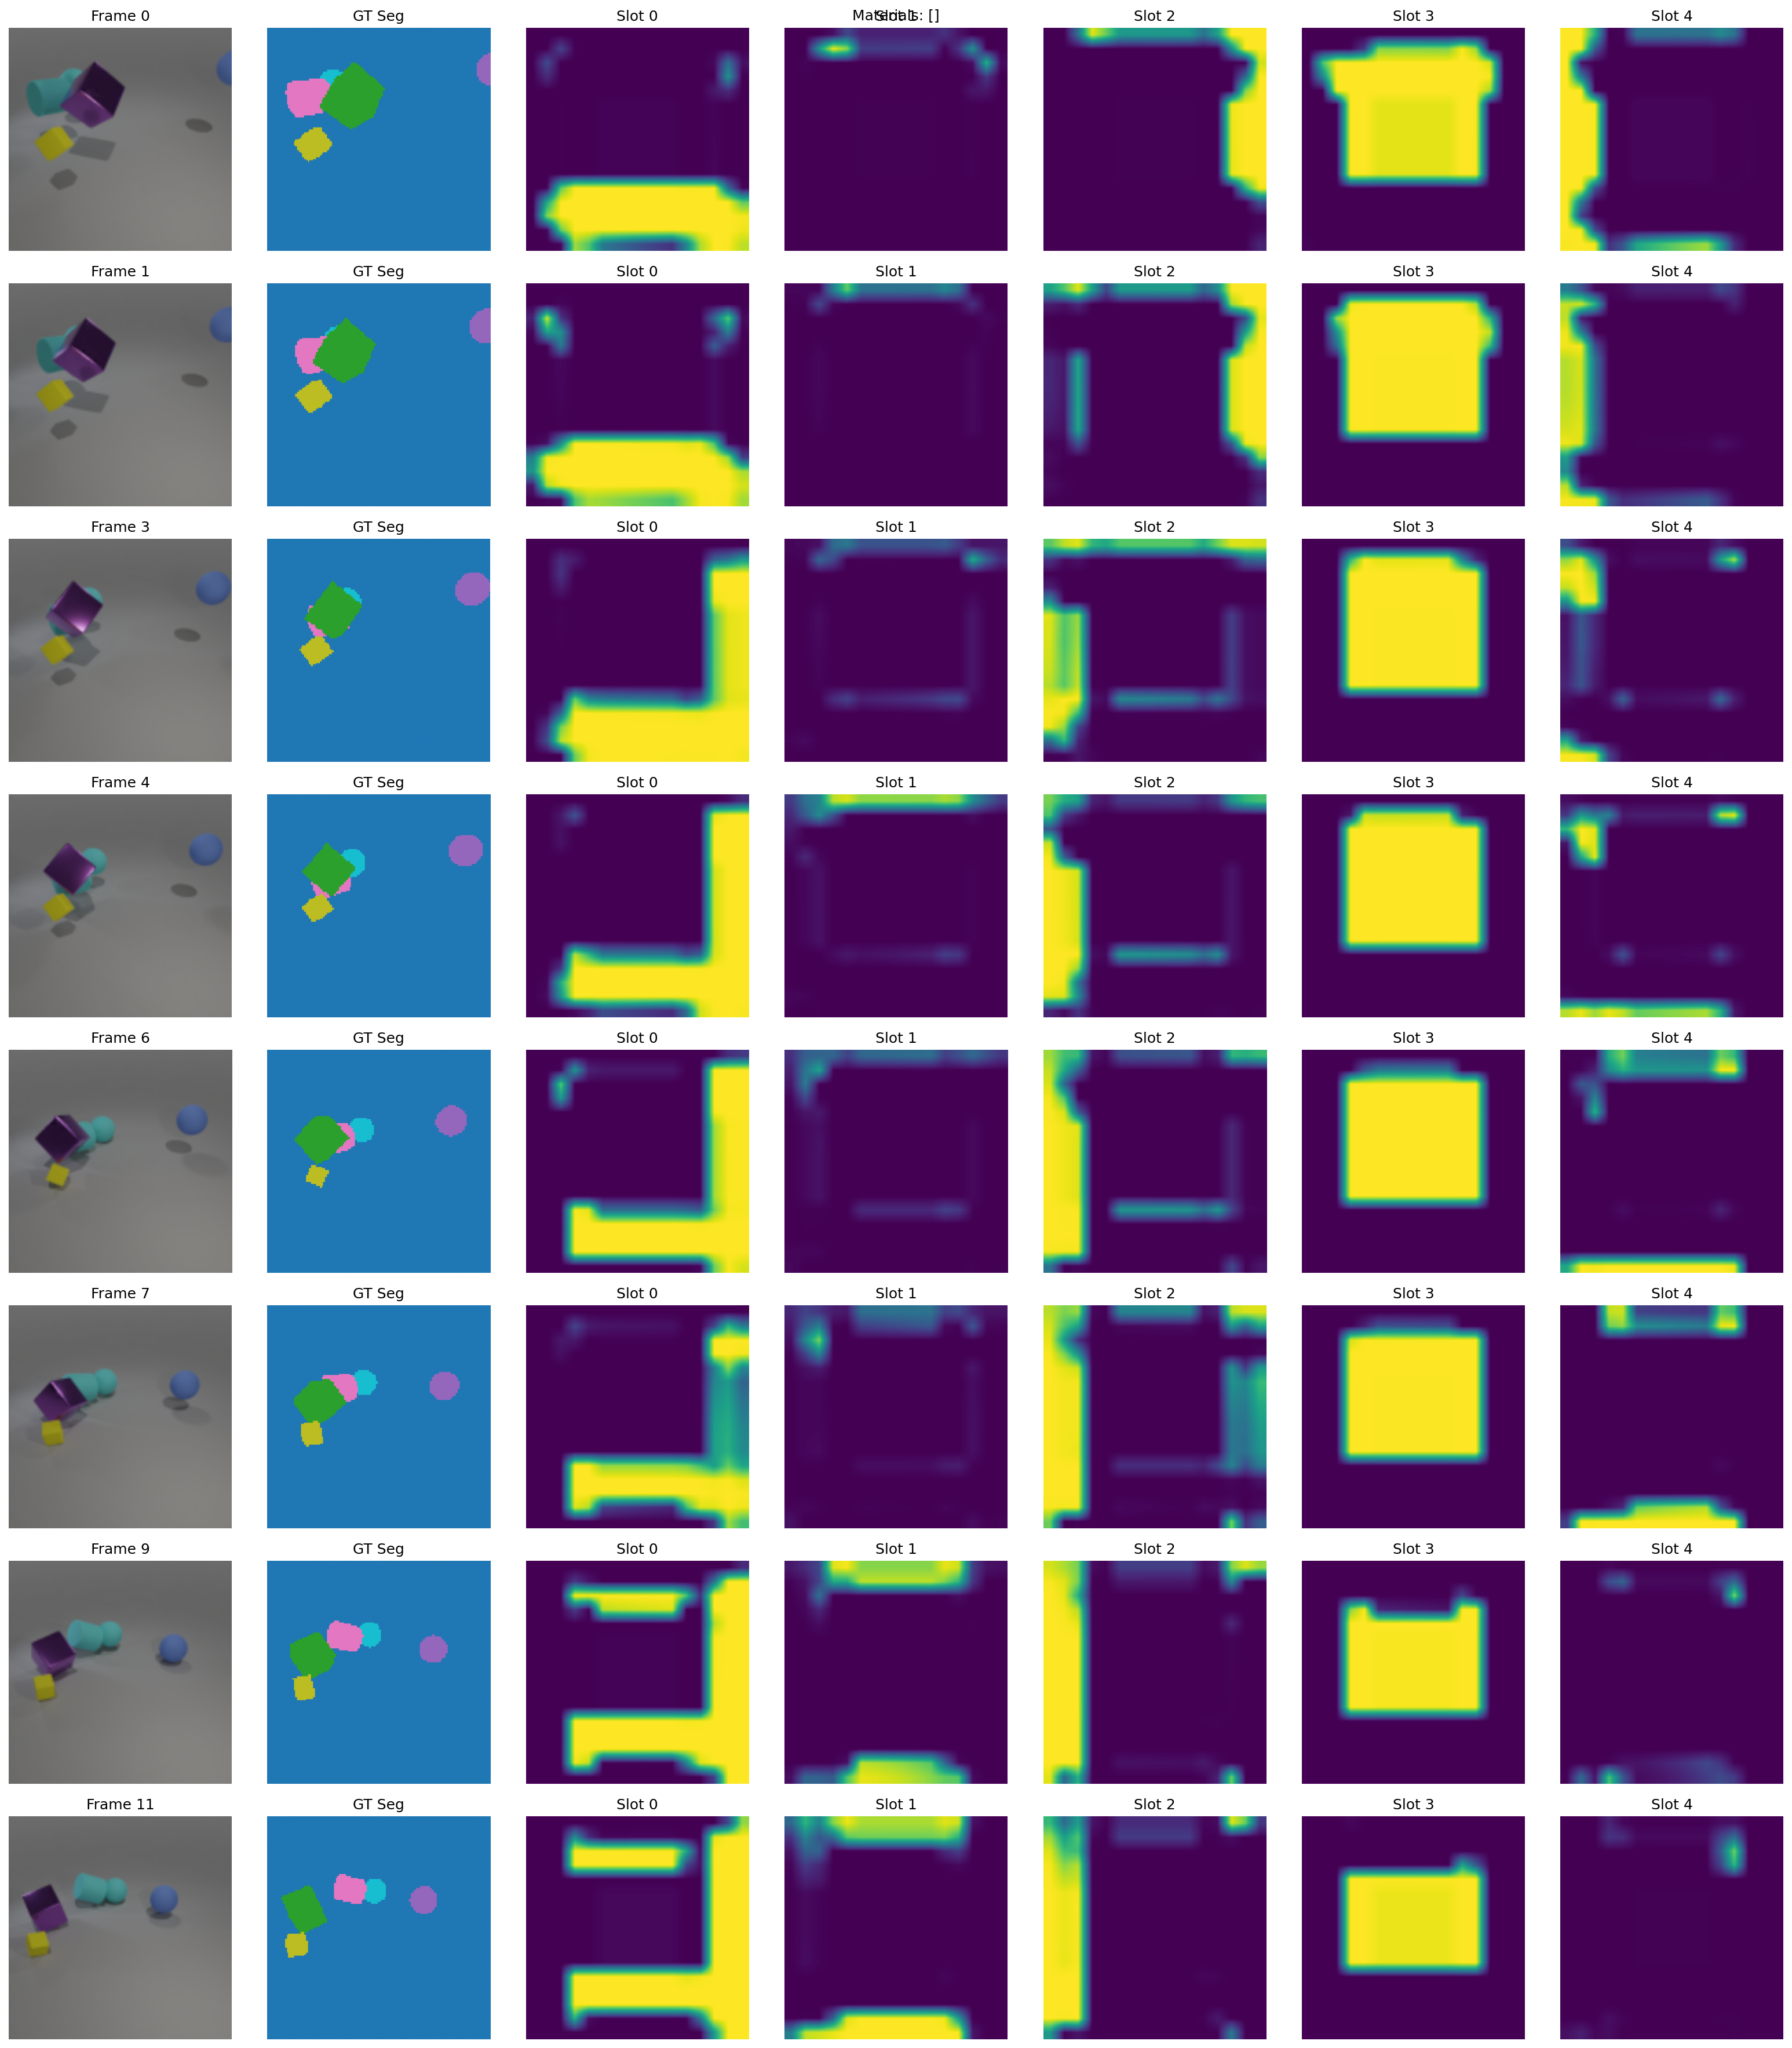

In [2]:
# マスク可視化結果
display(Image(filename='experiment_2026_02_01/movi_result.png', width=1000))

**マスク統計（多様性損失追加後）:**

| Slot | Coverage (>0.5) |
|------|----------------|
| 0 | 32.0% |
| 1 | 20.3% |
| 2 | 23.9% |
| 3 | 9.1% |
| 4 | 14.6% |
| **合計** | **99.9%** |

- 全スロットが活性化し、画像全体をカバー
- 多様性損失なしでは1スロットに集中していた問題を解決

### 3.3 Metal vs Mixed 比較

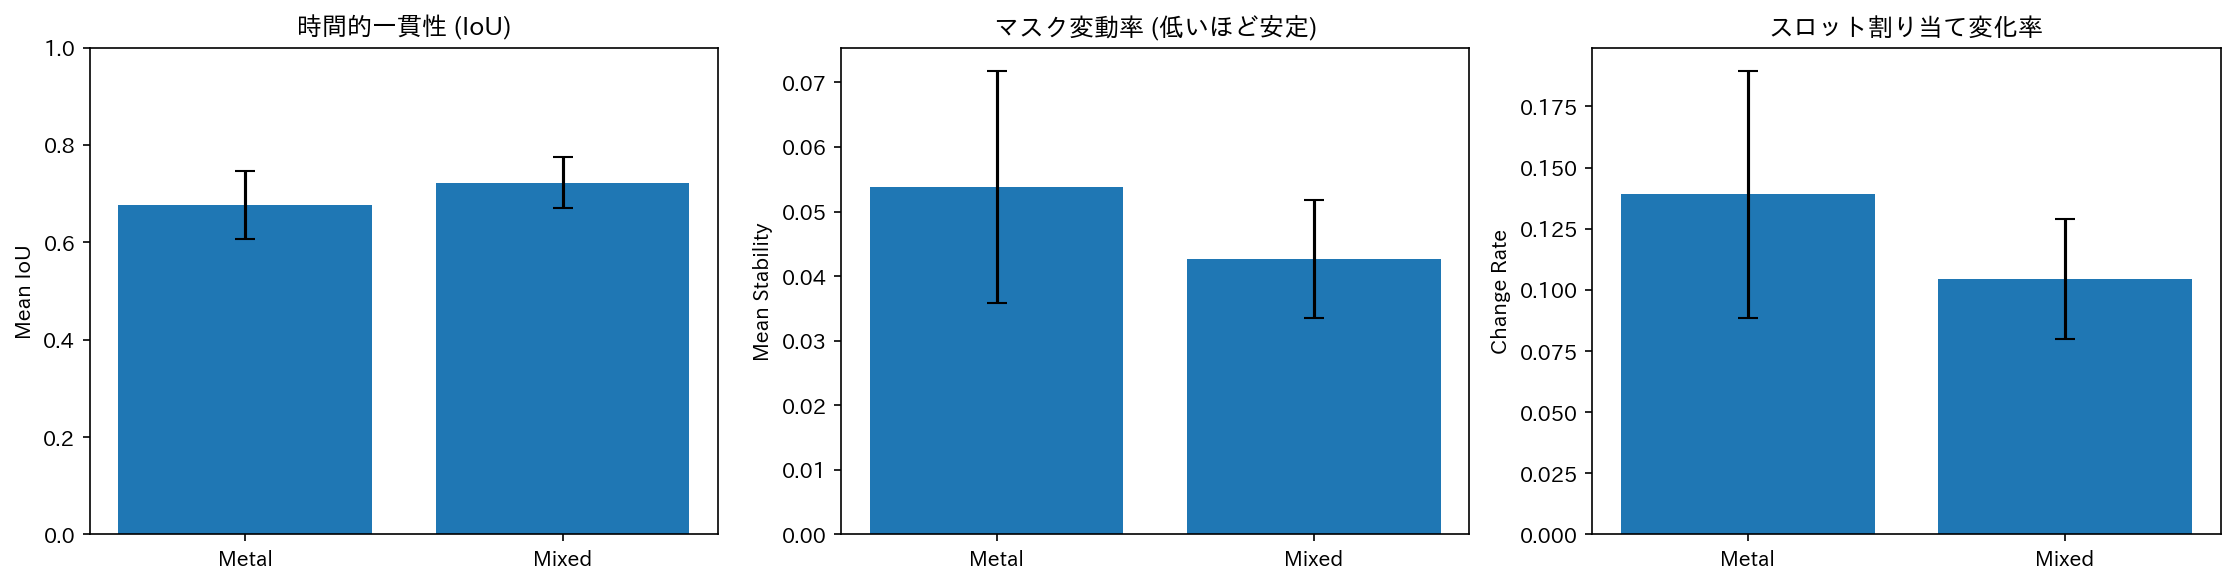

In [3]:
# Metal vs Mixed 分析結果
display(Image(filename='experiment_2026_02_01/metal_vs_mixed_analysis.png', width=1000))

**時間的一貫性の比較結果:**

| 指標 | Metal | Mixed | 差 | 解釈 |
|------|-------|-------|-----|------|
| Mean IoU ↑ | 0.660 ± 0.048 | 0.670 ± 0.029 | -0.010 | ほぼ同等 |
| Stability ↓ | 0.058 ± 0.014 | 0.045 ± 0.013 | +0.013 | Metalがやや不安定 |
| Change Rate ↓ | 0.147 ± 0.037 | 0.117 ± 0.039 | +0.030 | Metalで割り当て変化多い |

- ↑: 高いほど良い、↓: 低いほど良い

## 4. 考察

### 4.1 主要な発見

1. **Metal と Mixed で大きな差はない**
   - 時間的一貫性（IoU）は両者でほぼ同等（0.66 vs 0.67）
   - DINOv2の事前学習特徴量が鏡面反射の影響を吸収している可能性

2. **Metalで若干の不安定さが見られる**
   - Stability: +0.013（マスクの変動がやや大きい）
   - Change Rate: +0.030（スロット割り当ての変化がやや多い）
   - 鏡面反射による見えの変化が微小な影響を与えている

3. **多様性損失が重要**
   - 多様性損失なし: 1スロットに集中（スロット崩壊）
   - 多様性損失あり: 全5スロットが活性化

### 4.2 限界と今後の課題

1. **データセットの限界**
   - MOVi-Aは比較的単純なシーン
   - 実世界の複雑な鏡面反射は未検証

2. **定量評価の限界**
   - Ground-truthセグメンテーションとの比較（ARI, mIoU）は未実施
   - 現在はスロットマスクの統計的比較のみ

3. **今後の方向性**
   - より複雑なMOVi-C/Eでの検証
   - 実世界データセット（YCB-Videoなど）での評価
   - 鏡面反射の強度をパラメトリックに変化させた実験

## 5. 結論

SAVi-DINOSAURを用いた実験の結果、**鏡面反射物体（Metal）とマット物体（Mixed）の間で時間的一貫性に大きな差は見られなかった**。

これは、DINOv2の自己教師あり事前学習が、見えの変化に対してロバストな特徴量を学習していることを示唆する。ただし、Metalで若干の不安定さ（+3%の割り当て変化）が観察されており、より困難なシナリオでは差が顕著になる可能性がある。

**主な貢献:**
1. SAVi-DINOSAURのPyTorch実装
2. 多様性損失によるスロット崩壊の解決
3. Metal vs Rubberの時間的一貫性の定量評価

## 付録: コード

### 主要ファイル
- `src/savi_dinosaur.py`: SAVi-DINOSAURモデル実装
- `src/train_movi.py`: 学習スクリプト（多様性損失含む）
- `src/analyze_metal_vs_rubber.py`: Metal vs Mixed分析
- `src/download_movi.py`: データダウンロード

In [4]:
# モデル構造の確認
import sys
sys.path.append('..')
from src.savi_dinosaur import SAViDinosaur

model = SAViDinosaur(num_slots=5)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Frozen (DINOv2): {total_params - trainable_params:,}')

Loading DINOv2 model...


Using cache found in /home/menserve/.cache/torch/hub/facebookresearch_dinov2_main
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Total parameters: 33,001,217
Trainable parameters: 10,944,641
Frozen (DINOv2): 22,056,576
